# Atomic type spectroscopy (Haroche, pg. 853), <mark>without thermal losses</mark> 

1. **Introduction**
2. **Problem parameters**
3. **Setting up operators, Hamiltonian's, and the initial state**
4. **Probing qubit 1 with to a laser field** (No thermal losses considered)
    * Function generators
    * Plotting the pertubation
    * Plotting the results of the pertubation on the system
5. **Results**
    * Final state, Fidelity, Concurrence

<u>Author</u> : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
<u>Supervisor</u> : Yu-Chin Chao (ychao@fnal.gov) <br>
<u>Date</u>$\ \ \ \$: 16th July 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab.

## 1. Introduction

A probe laser fiels targets an atom (qubit 1) in an optical mutimode 3 cavity QED experiment. The probe field can be decribed as $E_p\ e^{-i\nu t}$
The code calculates the effect of such a pertubation on the system by demonstrating how the occupation probability of qubit 1 changes with time. It also shows how the pertubation afftects the rest of the components in the system.

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
from math import pi
from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [126]:
"""------------- FREQUENCIES --------------------"""
w_q1 = 2*pi*6.5;    # Qubit 1 frequency
w_q2 = 2*pi*6.8;    # Qubit 2 frequency: range from 1-9 GHz
w_f = 2*pi*7.1      # Resonator/ Filter frequency

W_p = 2*pi*6.5      # perturbing rabi frequency of the probing field
v_p = 2*pi*0.01   # parameter in the exponential of the pertubation
"""------------- COUPLING --------------------"""
g_f1 = 2*pi*0.118    # Filter-filter coupling
g_f2 = 2*pi*0.344 
g_q1f = 2*pi*0.135   # qubit 1-fitler coupling
g_q2f = 2*pi*0.415   # qubit 2-fitler coupling

numF = 3            # number of filters
N = 2               # number of fock states 

times = np.linspace(0,100,500)
w_plist = np.linspace(1, 13, 200)
width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * g_q1f)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*pi)/(4 * g_q2f)                                           

## 3. Setting up the operators, Hamiltonian's, and Initial state

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator

In [127]:
def Hqubit(sz):
  """ 
  Comuptes the qubit hamiltonian
  @param sz :: Pauli's z matrix
  @param w_q :: qubit frequency
  """
  return 0.5*sz

def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def sumDagger(m):
  """
  Computes sum of operator m and m.dag()
  @param a1 :: destruction operator 1
  @param a2 :: destruction operator 2
  """
  return m+m.dag()

### 3.1 Operators 

In [128]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), qeye(N), destroy(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

# collapse operators
c_ops = []

### 3.2 Hamiltonian's and initial state

In [129]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 = Hqubit(sz1)       
Hq2 = Hqubit(sz2)

# Filter Hamiltonians (refer formula in the Introduction)
H_f1 = tensor(destroy(N),create(N),qeye(N),qeye(2), qeye(2)) + tensor(create(N),destroy(N),qeye(N),qeye(2), qeye(2))
H_f2 = tensor(qeye(N),create(N),destroy(N),qeye(2), qeye(2)) + tensor(qeye(N),destroy(N),create(N),qeye(2), qeye(2))

Hf = numOp(a1) + numOp(a2) + numOp(a3)    
H_f12 = g_f1*H_f1+g_f2*H_f2

# Qubit-Filter Hamiltonian
H_qf1 = tensor(destroy(N),qeye(N), qeye(N), sigmap(),qeye(2))
H_qf2 = tensor(qeye(N),qeye(N), destroy(N), qeye(2), sigmap())

Hqf = g_q1f*sumDagger(H_qf1) + g_q2f*sumDagger(H_qf2)

# time-independent Hamiltonian (see later)
H0 = H_f12+Hqf
 
H = H0+ w_q1*Hq1 + w_q2*Hq2 + w_f*Hf  # Resultant Hamiltonian

### 3.3 Initial State

In [130]:
# initial state of the system. Qubit 1: excited, Qubit 2: ground st.
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), basis(2,1), basis(2,0))

## 4. Probing qubit 1 with to a laser field

Tranformations on closed quantum states can be modelled by unitary operators. The combined time-dependent Hamiltonian for a system undergoing a tranformation that can be representated as,
$$ H(t) = H_0 - f_1(t)H_1 - f_2(t)H_2$$
where $H_0$ is called the time-independent drift Hamiltonian, $\ H_1 = \sigma_1^+$, and $\ H_2 = \sigma_1^-$ are the control Hamiltonians with a time varying amplitude $f_1(t) = \Omega_pe^{-i\nu t}$ and $f_2(t) = \Omega_pe^{i\nu t}$.

Here we write the Hamiltonian in a function-based time dependent way. See other ways [here](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html). Here the time-dependent coefficients, $f_n(t)$ of the Hamiltonian (e.g. `wf_t, w1_t,w2_t`) are expressed using Python functions 

### 4.1 Function generators

In [131]:
def H1_coeff(t, args):
  W_p = args['Omega']
  nu = args['nu']
  return -W_p*np.exp(-t*nu)

def H2_coeff(t, args):
  W_p = args['Omega']
  nu = args['nu']
  return -W_p*np.exp(t*nu)

In [132]:
# time dependent Hamiltonian
args = {'Omega': 7, 'nu': 1}
H1 = sm1.dag()

H_t = [H, [sm1.dag(), H1_coeff], [sm1, H2_coeff]]

# Evolving the system
output = mesolve(H_t, psi0, times, c_ops, [n1, n2, numOp(a1), numOp(a2), numOp(a3)], args=args)

### 4.2 Plotting the pertubation

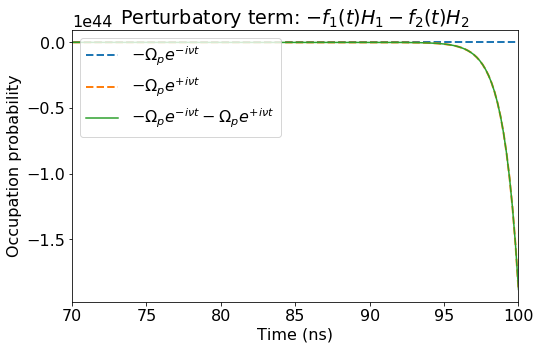

In [133]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times, [H1_coeff(t, args=args)for t in times], '--', linewidth=2, label=r"$- \Omega_pe^{-i\nu t}$" )
ax.plot(times, [H2_coeff(t, args=args)for t in times], '--', linewidth=2, label=r"$- \Omega_pe^{+i\nu t}$")
ax.plot(times, [H1_coeff(t, args=args)+H2_coeff(t, args=args)for t in times], label=r"$- \Omega_pe^{-i\nu t}- \Omega_pe^{+i\nu t}$")
ax.legend(loc="upper left")
ax.set_xlabel('Time (ns)')
ax.set_xlim(70, 100)
ax.set_ylabel('Occupation probability')
ax.set_title(r'Perturbatory term: $- f_1(t)H_1 - f_2(t)H_2$ ');

### 4.3 Plotting the results (No thermal losses)

For different combinations of qubit and cavity. 

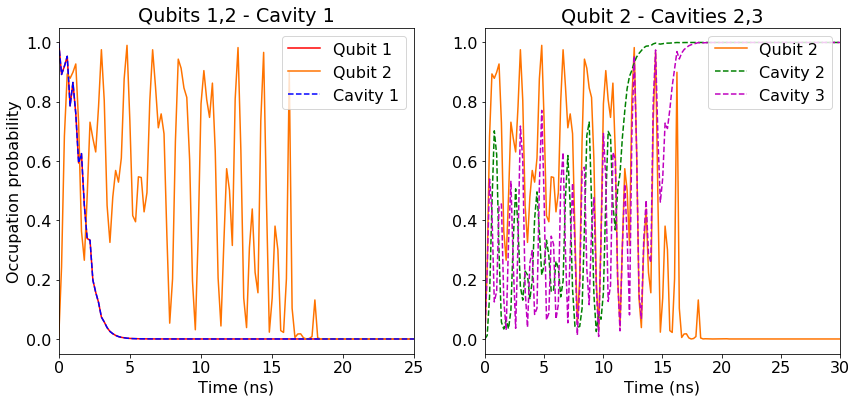

In [136]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(times, output.expect[0], 'r', label="Qubit 1")
ax[0].plot(times, output.expect[1], '#ff7300', label="Qubit 2")
ax[0].plot(times, output.expect[0], 'b--', label="Cavity 1")
ax[0].set_xlabel('Time (ns)');
ax[0].set_xlim(0, 25)
ax[0].set_ylabel('Occupation probability');
ax[0].set_title('Qubits 1,2 - Cavity 1');
ax[0].legend(loc="upper right")

ax[1].plot(times, output.expect[1], '#ff7300', label="Qubit 2")
ax[1].plot(times, output.expect[3], 'g--', label="Cavity 2")
ax[1].plot(times, output.expect[4], 'm--',label="Cavity 3")
ax[1].set_xlabel('Time (ns)')
ax[1].set_xlim(0, 30)
ax[1].set_title('Qubit 2 - Cavities 2,3');
ax[1].legend(loc="upper right")

## 5. Scanning parameter space of the peturbing frequency (work in progress-- ??)

In [135]:
def probe(w_plist):
    [args = {'Omega': w_p, 'nu': 1} for w_d in w_plist]

    H_t = [H, [sm1.dag(), H1_coeff], [sm1, H2_coeff]]

    # Evolving the system
    output = mesolve(H_t, psi0, times, c_ops, [n1], args=args)
    return 

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(w_plist, [H1_coeff(t, args=args)for t in times], '--', linewidth=2, label=r"$- \Omega_pe^{-i\nu t}$" )